In [1]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [2]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z'}, plus_minus: Optional[dict] = {0: 'z'}) -> QuantumCircuit:
    """For BB84, we take state to be '0', '1', '+', '-' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(1)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[0] == '+':
        qc.h(0)
    if state[0] == '-':
        qc.x(0)
        qc.h(0)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
                
    # apply the Hadamard to obtain + and - state
    for gate, hadamard in plus_minus.items():
        if gate > 1:
            raise ValueError('Provided H Gate number exceeds in the circuit for + or - State')
        else:
            if hadamard == 'h' or hadamard == 'H':
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [3]:
print(create_circuit('1',100))

        ┌───┐┌────────────────┐ ░ ┌─┐
     q: ┤ X ├┤ Delay(100[ns]) ├─░─┤M├
        └───┘└────────────────┘ ░ └╥┘
meas: 1/═══════════════════════════╩═
                                   0 


In [4]:
print(create_circuit('-',100,{0: 'z'},{0: 'h'}))

        ┌───┐┌───┐┌────────────────┐┌───┐ ░ ┌─┐
     q: ┤ X ├┤ H ├┤ Delay(100[ns]) ├┤ H ├─░─┤M├
        └───┘└───┘└────────────────┘└───┘ ░ └╥┘
meas: 1/═════════════════════════════════════╩═
                                             0 


In [6]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","id"])
        
    
    return noise_model

In [7]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['id', 'measure', 'h', 'x', 'delay']>

In [8]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['measure', 'delay']>

In [9]:
noise_params = {"T1":193020, "T2":257470} # ibmq_armonk T1: 193.02 , T2:257.47 us
q1_gate_len = 71 # 7.111111111111111e-08
measure_len = 4977.778 # ibmq_armonk  4977.778 

In [10]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for BB84 protocol"""
    """Channel: 1 => |0>+|1>, 2 => |0>+|1> 3 =>|0>+|1>  4=>|0>+|1> """
    
    if channel == '1':
        state = '0'
    elif channel == '2':
        state = '1'
    elif channel == '3':
        state = '+'
    elif channel == '4':
        state = '-'  
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    #print(counts)
    success = 0
    
    if channel == '1':
        if '0' in counts.keys():
            success += counts['0']
        else:
            success +=0
#         if '1' in counts.keys():
#             success += counts['1']
    elif channel == '2':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']
        else:
            success +=0
    elif channel == '3':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
    elif channel == '4':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
            
    
    return float(success/shots)

In [11]:
run('2',1000,{"delay": True, "measure": True, "gate": True})

0.963

In [12]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

1.0

In [13]:
run('3',1000,{"delay": True, "measure": True, "gate": True})

1.012

In [14]:
run('4',1000,{"delay": True, "measure": True, "gate": True})

0.952

# Total Probability of Success Graph

# Delay 

In [15]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist=[]
for j in range(20):
    for i in range(len(state_list)):
        delay = np.arange(0,1001000,1000)
        channel = state_list[i]
        apply_error = {"delay":True, "measure": False, "gate": False}
        success = []

        # need to run in multiple loops to get a smoother curve
        for d in range(len(delay)):
            prob = run(channel,int(delay[d]),apply_error)
            success.append(prob)
        totalplist.append(success)

In [16]:
from statistics import mean
a= totalplist
print(*map(mean, zip(*a)))

0.998375 0.99485 0.9948 0.9941 0.9899625 0.9864625 0.9851 0.9841125 0.9795 0.9782 0.9754625 0.9723999999999999 0.9719249999999999 0.969075 0.965625 0.9625375 0.9614125 0.9591 0.954625 0.955725 0.9503 0.946775 0.943175 0.9451625 0.9410625 0.9396125 0.9368 0.9351875 0.9312 0.929725 0.9279000000000001 0.9288625 0.9256 0.9252375 0.918225 0.9169125 0.9155125000000001 0.913525 0.9124125 0.90745 0.9075 0.906725 0.9027625 0.9012625 0.897425 0.898375 0.8943625000000001 0.890175 0.88905 0.8880125 0.8847375 0.8847875000000001 0.881625 0.8765125 0.8795125 0.8775375 0.87455 0.871725 0.869075 0.8687374999999999 0.8655125 0.8658125 0.8613125 0.8599375 0.8609125 0.856125 0.8526 0.8544375 0.851 0.849375 0.8492375 0.846625 0.8437125 0.84385 0.8428249999999999 0.8413875 0.83695 0.83585 0.83295 0.83325 0.8291 0.828975 0.82595 0.8245 0.8230375 0.8220625 0.82245 0.8182 0.817525 0.8154625 0.814975 0.8153 0.8102 0.8109 0.80635 0.8049875 0.8049000000000001 0.8032625 0.8013125 0.7962625 0.7958625 0.79555 0.7950

In [ ]:
success=[0.998375,0.99485,0.9948,0.9941,0.9899625,0.9864625,0.9851,0.9841125,0.9795,0.9782,0.9754625,0.9723999999999999,0.9719249999999999,0.969075,0.965625,0.9625375,0.9614125,0.9591,0.954625,0.955725,0.9503,0.946775,0.943175,0.9451625,0.9410625,0.9396125,0.9368,0.9351875,0.9312,0.929725,0.9279000000000001,0.9288625,0.9256,0.9252375,0.918225,0.9169125,0.9155125000000001,0.913525,0.9124125,0.90745,0.9075,0.906725,0.9027625,0.9012625,0.897425,0.898375,0.8943625000000001,0.890175,0.88905,0.8880125,0.8847375,0.8847875000000001,0.881625,0.8765125,0.8795125,0.8775375,0.87455,0.871725,0.869075,0.8687374999999999,0.8655125,0.8658125,0.8613125,0.8599375,0.8609125,0.856125,0.8526,0.8544375,0.851,0.849375,0.8492375,0.846625,0.8437125,0.84385,0.8428249999999999,0.8413875,0.83695,0.83585,0.83295,0.83325,0.8291,0.828975,0.82595,0.8245,0.8230375,0.8220625,0.82245,0.8182,0.817525,0.8154625,0.814975,0.8153,0.8102,0.8109,0.80635,0.8049875,0.8049000000000001,0.8032625,0.8013125,0.7962625,0.7958625,0.79555,0.79505,0.7953625,0.7877625,0.79155,0.78815,0.7881625,0.7849375000000001,0.7860625,0.7822,0.7826500000000001,0.7811,0.7810375,0.7766500000000001,0.773325,0.7738,0.7720125,0.7699875,0.770325,0.76905,0.7662625000000001,0.765925,0.76385,0.762,0.75895,0.7603625,0.7578375,0.75665,0.754325,0.7547,0.7527375,0.7514125,0.750325,0.7476125,0.746775,0.7481625,0.743675,0.746025,0.7432124999999999,0.741225,0.7397875,0.739625,0.7374875,0.7370375,0.735275,0.7366,0.73465,0.7327625,0.7328875,0.7317875,0.7291124999999999,0.729125,0.7263999999999999,0.7246374999999999,0.7233625,0.7231,0.722625,0.7218625,0.72215,0.71715,0.716875,0.7158125,0.7180875,0.7118625,0.7117375,0.711175,0.7098375,0.7089,0.709625,0.7089,0.7051499999999999,0.705825,0.7046125,0.7039124999999999,0.702175,0.7033375,0.6990999999999999,0.6977625,0.6977375,0.697325,0.6970625,0.694775,0.69415,0.6912874999999999,0.69345,0.690275,0.6900375,0.68755,0.6881125,0.6849125,0.6872125,0.683875,0.684075,0.6800125,0.6819625,0.6819875,0.6789375,0.6787875,0.6772625,0.6783,0.6782875,0.6760875000000001,0.6738125,0.6740375,0.6733375,0.6712875,0.6714125,0.6694375,0.6687625,0.66815,0.668075,0.6671875,0.663,0.667725,0.6641625,0.6649125,0.66415,0.6614375,0.6629625,0.661325,0.656375,0.65745,0.6568375,0.6586875,0.655425,0.6557000000000001,0.6521,0.6532625,0.6518125,0.6515875,0.6485375,0.6493375,0.6486500000000001,0.6500375,0.647425,0.6479375,0.6458875000000001,0.6474375,0.64345,0.64455,0.6439125,0.640125,0.6410625,0.6423375,0.641575,0.640575,0.63945,0.6387625,0.637175,0.637775,0.636475,0.6368,0.635825,0.6360875,0.63445,0.632275,0.6330125,0.6321375,0.629575,0.630475,0.630625,0.6282125,0.6279625,0.6256625,0.62725,0.6254,0.62545,0.622925,0.6235375,0.62195,0.623825,0.6220125,0.6219,0.6203375,0.620575,0.6186875,0.6207625,0.6174375,0.6192625,0.6159375,0.6156375,0.617225,0.615875,0.6140125,0.613375,0.6134625,0.612225,0.6119125,0.611575,0.61035,0.6105125,0.6116,0.61,0.6069,0.6088125,0.6082,0.6074875,0.6065125,0.60715,0.6042625,0.6053375,0.604225,0.6038625,0.6051875,0.602425,0.602975,0.6036625,0.6030625,0.601275,0.6002125,0.5987875,0.598375,0.598425,0.5981375,0.5972375,0.59695,0.5978249999999999,0.5956375,0.5952375,0.5954,0.5946625,0.5939375,0.594225,0.5935625,0.5928,0.5924875,0.5921375,0.5915625,0.5905874999999999,0.5897125,0.589,0.591,0.5891875,0.5878875,0.5886625,0.5868125,0.5862875,0.5880875,0.585575,0.5843875,0.585675,0.5851,0.586525,0.5845,0.5831375,0.5838249999999999,0.5832875,0.5825,0.5832999999999999,0.581125,0.582125,0.581475,0.5793375,0.5789624999999999,0.5796,0.5796375,0.5761625,0.5781375,0.577225,0.5765875,0.5777,0.5769124999999999,0.57635,0.5761499999999999,0.5751499999999999,0.5755625,0.5738375,0.57465,0.5777,0.5744625,0.5742375,0.5736749999999999,0.5722125,0.57185,0.571425,0.571775,0.570875,0.5705125,0.5692125,0.570175,0.569125,0.5688,0.5675749999999999,0.5692375,0.56895,0.566525,0.56665,0.5663,0.5677875,0.568175,0.5651875,0.5662,0.5653625,0.565675,0.565025,0.563475,0.5638,0.5656125,0.5633125,0.5621,0.5613125,0.5613375,0.5611875,0.5615375,0.5616375,0.560725,0.5599125,0.55975,0.5596625000000001,0.55845,0.5604875,0.5591375000000001,0.559625,0.559375,0.5566875,0.5581875000000001,0.55815,0.55835,0.5566875,0.55655,0.556575,0.5561625,0.555825,0.5558500000000001,0.5558375,0.555825,0.5542,0.5538625,0.5548,0.5538375,0.553775,0.5528375,0.5549875,0.5525875,0.551,0.552925,0.55305,0.55215,0.5493125,0.551825,0.551125,0.5512375,0.5502375,0.5498000000000001,0.5495625000000001,0.5505375,0.5485,0.5498500000000001,0.55055,0.548025,0.5490375000000001,0.547525,0.5481875,0.5478625,0.5462375,0.5476,0.5472125,0.5446125,0.5462750000000001,0.5472875,0.5464625000000001,0.5452125,0.54645,0.5453,0.5450375000000001,0.5451,0.5453250000000001,0.5454625000000001,0.545525,0.544875,0.54365,0.5432750000000001,0.5425875,0.54155,0.5422125,0.542925,0.541825,0.5419125,0.5423875,0.541925,0.5411875,0.5410875,0.5416625,0.5407125,0.5412750000000001,0.5409375000000001,0.5399875000000001,0.53985,0.5395,0.5403,0.5381375,0.539525,0.5404375,0.53825,0.5386125,0.5381625,0.5388625,0.539025,0.5387125,0.5378125,0.5388875,0.5362625,0.5364,0.53755,0.53715,0.5367125,0.5365875,0.5363625,0.536375,0.5355875,0.5350875,0.5351875,0.534575,0.534075,0.5355125000000001,0.533075,0.5349375000000001,0.5338,0.533725,0.53395,0.5334875,0.534125,0.53335,0.53195,0.5323,0.5322,0.5326375,0.5332875,0.53215,0.53235,0.53105,0.531625,0.5318375,0.532575,0.53185,0.53085,0.5312625,0.530075,0.5316125,0.53055,0.5301375,0.5298875000000001,0.5290875,0.5290125,0.5286,0.5302,0.530475,0.5305125,0.528875,0.5292125,0.5302375,0.52905,0.5285625,0.5284875,0.528775,0.527225,0.5281625,0.5282250000000001,0.5276,0.5266875,0.5285,0.5275,0.526925,0.5271875,0.527525,0.526825,0.5265875,0.526375,0.5271875,0.5263125,0.5261,0.5260125,0.525525,0.5257375,0.5247625,0.524675,0.524975,0.52585,0.52545,0.5238,0.5249625,0.524675,0.52415,0.5242625,0.5240625,0.5234625,0.52425,0.5243875,0.5240875,0.522525,0.5242875,0.523775,0.522875,0.5226125,0.5231125,0.5225375,0.522725,0.5215,0.522375,0.523575,0.5220875,0.5218875000000001,0.521925,0.5222125,0.5215125,0.5214125000000001,0.5212375,0.52075,0.52135,0.5220875,0.5212375,0.5219,0.52145,0.5213,0.5214,0.5209625,0.521225,0.51995,0.5202625,0.5203625000000001,0.52,0.521225,0.519275,0.5197625,0.5195625,0.5192,0.5193625000000001,0.5192875,0.51935,0.519775,0.5186875,0.51885,0.5200625,0.5186875,0.517775,0.51835,0.518,0.5185375,0.5186375,0.518,0.517275,0.517875,0.5179625,0.5176000000000001,0.518,0.517425,0.51695,0.517,0.51725,0.5166125,0.51805,0.516825,0.5166000000000001,0.5169625,0.5170375,0.5162875,0.5156000000000001,0.5170750000000001,0.5166625,0.516175,0.5164375,0.5164125,0.516175,0.5162625,0.5156875,0.5155,0.5161250000000001,0.515975,0.5159625,0.51475,0.5154125,0.515875,0.5160375,0.515425,0.513775,0.515475,0.5151125,0.515175,0.5147,0.514275,0.5150375,0.5143875,0.5143625000000001,0.5147625,0.51475,0.51465,0.5141375,0.514375,0.513475,0.5138,0.5139875,0.5130875,0.5142625,0.51395,0.5136875,0.51335,0.5134625,0.514025,0.5139375,0.5130625,0.51345,0.5132875,0.5126375,0.512725,0.5128375000000001,0.5127625,0.51285,0.5130625,0.5123625,0.51265,0.512,0.5129125,0.5119625,0.512425,0.5121375,0.5121,0.511925,0.5123375,0.5127375,0.511925,0.511825,0.5122,0.5118875,0.5120375,0.511875,0.5112,0.51195,0.5113625,0.51165,0.5108125,0.5109,0.5111625,0.5116625,0.51125,0.5115625,0.5114875,0.5115,0.5115125,0.51045,0.5116125,0.510525,0.5106,0.5109,0.5101875,0.5103875,0.5099375,0.5108125,0.5102125,0.5106125,0.50995,0.5098875,0.5105875,0.51035,0.5104875,0.509625,0.5100375,0.510175,0.5100750000000001,0.5095625,0.5095125,0.5097375,0.510025,0.5099875,0.5090375,0.5096,0.509775,0.509625,0.5098,0.509,0.5091625,0.508975,0.5091375,0.5085875,0.508875,0.509425,0.50875,0.509175,0.50945,0.509,0.508925,0.5092125,0.5084875,0.50815,0.5082875,0.5086625,0.5090125,0.50835,0.5085875,0.5083,0.5084625,0.5081875,0.5086,0.5083625,0.50875,0.50835,0.508525,0.50825,0.50825,0.5075875,0.50835,0.507925,0.507875,0.507025,0.507075,0.507725,0.507475,0.5077125,0.5080125,0.507425,0.5079375,0.5076625,0.507375,0.5075,0.5072625,0.506975,0.5074,0.5073,0.50735,0.507675,0.507175,0.507125,0.5069,0.5065875,0.507075,0.5070625,0.5067,0.507025,0.5069625,0.5063125,0.5063125,0.50695,0.506475,0.5065,0.5074,0.5063375,0.506575,0.506375,0.50625,0.5062375,0.50625,0.5065125,0.5066875,0.5062625,0.5060125,0.5068375,0.5061875,0.506175,0.5059375,0.506225,0.506425,0.5060375,0.5059875,0.5064,0.50545,0.50565,0.50605,0.5057125,0.5057,0.5058125,0.5054125,0.505725,0.50565,0.5057375,0.5054625,0.5060250000000001,0.5053625,0.5061375,0.5055125,0.5057,0.50555,0.5056125,0.5053375,0.50545,0.50515,0.50585,0.505225,0.5054375,0.5051125,0.5053875,0.5056875,0.5056625,0.5047625,0.504875,0.505375,0.505175,0.505175,0.50485,0.50475,0.5051,0.504675,0.5048125,0.5053375,0.504925,0.5054375,0.504525,0.5050375,0.504825,0.504675,0.5049125,0.504875,0.5051375,0.50485,0.504725,0.5050250000000001,0.5044375,0.5045375,0.5043375,0.505,0.5045,0.50395,0.50475,0.5045375,0.5041125,0.5042,0.504275,0.5045625,0.5044375,0.5040625,0.504275,0.5044,0.5043875,0.5042,0.50435,0.504175,0.5042125,0.5041125,0.503925,0.5039625,0.50395,0.5040125,0.5040375,0.5038875,0.5040250000000001,0.50375,0.504125,0.5043375,0.5039,0.50355,0.5039875,0.503975,0.5038875,0.503375,0.5037375,0.503725,0.5040250000000001,0.503675,0.50375,0.5038375,0.5033625,0.5038875,0.5037625,0.5036,0.5032375,0.503575,0.5033375,0.5038125,0.50345,0.5039,0.5036375,0.5032,0.5037375,0.503175,0.50365,0.5035125,0.503425,0.5034375,0.5035125,0.503625,0.5034625,0.5031625,0.5036125,0.502925,0.50305,0.50325,0.50315,0.5033,0.5029875,0.5032625000000001,0.50335,0.502875,0.5029375,0.503125,0.5028375,0.5031375,0.50325,0.5030125,0.5029875,0.5028,0.5029,0.5028125,0.5028875,0.503025,0.5032,0.50265,0.5031,0.5028625,0.5029375,0.5029625,0.5031875,0.50285]


In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "Error on channel length")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "Error on channel length")
ax.legend()

# Delay + Measure

In [ ]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist1=[]
for j in range(20):
    for i in range(len(state_list)):
        delay = np.arange(0,1001000,1000)
        channel = state_list[i]
        apply_error = {"delay":True, "measure": True, "gate": False}
        success = []

        # need to run in multiple loops to get a smoother curve
        for d in range(len(delay)):
            prob = run(channel,int(delay[d]),apply_error)
            success.append(prob)
        totalplist1.append(success)

In [ ]:
from statistics import mean
a= totalplist1
print(*map(mean, zip(*a)))

In [25]:
success1 =[]



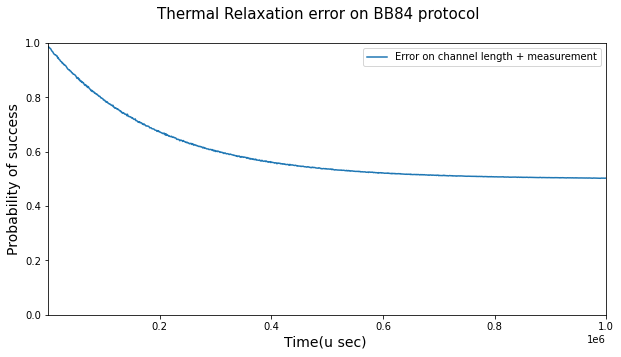

<Figure size 576x360 with 0 Axes>

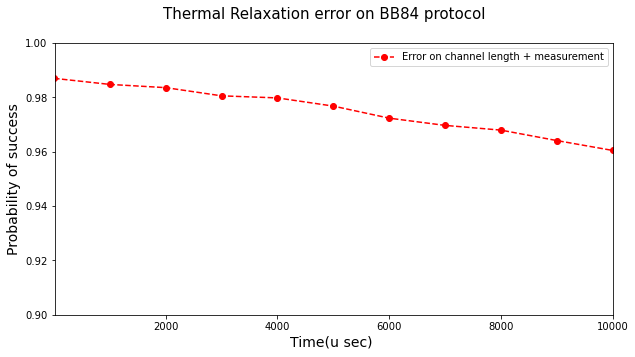

<Figure size 576x360 with 0 Axes>

In [26]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success1,label = "Error on channel length + measurement")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success1,'ro--',label = "Error on channel length + measurement")
ax.legend()

# Delay + gates

In [ ]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist2=[]
for j in range(20):
    for i in range(len(state_list)):
        delay = np.arange(0,1001000,1000)
        channel = state_list[i]
        apply_error = {"delay":True, "measure": True, "gate": False}
        success = []

        # need to run in multiple loops to get a smoother curve
        for d in range(len(delay)):
            prob = run(channel,int(delay[d]),apply_error)
            success.append(prob)
        totalplist2.append(success)

In [ ]:
from statistics import mean
a= totalplist2
print(*map(mean, zip(*a)))

In [29]:
success2=[]


In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success2,label = "Error on channel length + Gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success2,'ro--',label = "Error on channel length + Gates")
ax.legend()

# Delay + Measure + Gate

In [ ]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist3=[]
for j in range(20):
    for i in range(len(state_list)):
        delay = np.arange(0,1001000,1000)
        channel = state_list[i]
        apply_error = {"delay":True, "measure": True, "gate": True}
        success = []

        # need to run in multiple loops to get a smoother curve
        for d in range(len(delay)):
            prob = run(channel,int(delay[d]),apply_error)
            success.append(prob)
        totalplist3.append(success)

In [ ]:
from statistics import mean
a= totalplist3
print(*map(mean, zip(*a)))

In [35]:
success3=[]


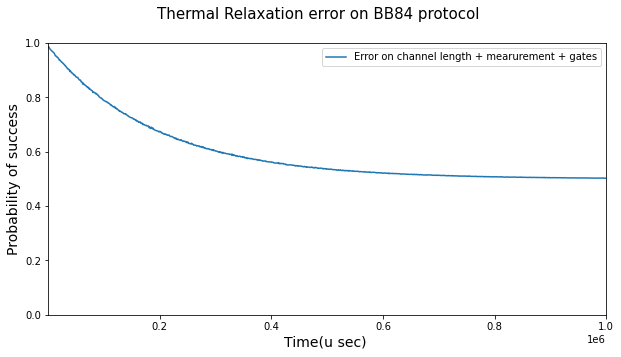

<Figure size 576x360 with 0 Axes>

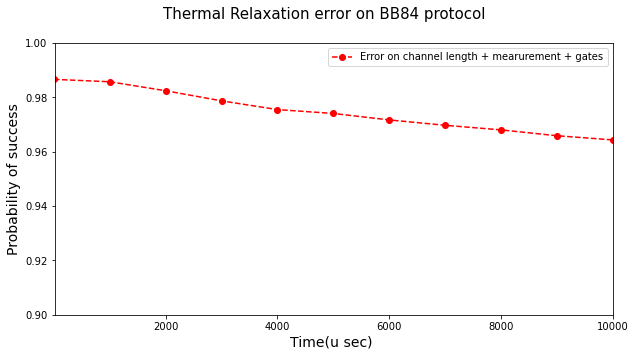

<Figure size 576x360 with 0 Axes>

In [36]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success3,label = "Error on channel length + mearurement + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success3,'ro--',label = "Error on channel length + mearurement + gates")
ax.legend()

# All Graph Combine

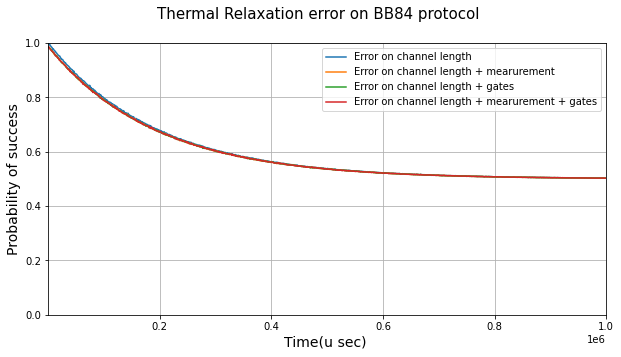

<Figure size 576x360 with 0 Axes>

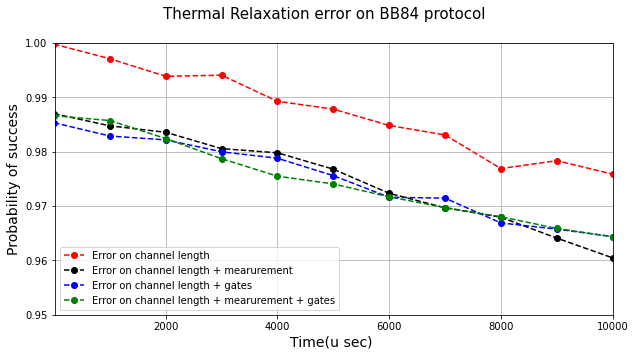

<Figure size 576x360 with 0 Axes>

In [41]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "Error on channel length")
ax.plot(delay,success1,label = "Error on channel length + mearurement")
ax.plot(delay,success2,label = "Error on channel length + gates")
ax.plot(delay,success3,label = "Error on channel length + mearurement + gates")
ax.legend()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.95,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "Error on channel length")
ax.plot(delay,success1,'ko--',label = "Error on channel length + mearurement")
ax.plot(delay,success2,'bo--',label = "Error on channel length + gates")
ax.plot(delay,success3,'go--',label = "Error on channel length + mearurement + gates")
ax.legend()
